In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy

from scripts.utils import drop_similar, update_occupations, filter_rare_occupations, filter_outlier_wikidata

from fuzzywuzzy import fuzz
import ruptures as rpt  


from os.path import join
import json

df = pd.read_csv("data/preprocessed.csv")

import pickle
with open("data/embeds.pkl", "rb") as f:
    embeds = pickle.load(f)

In [4]:
df['publish_date'] = df['d'].apply(lambda x: x[:10])

> In the next cells we will conduct unsupervised segmentation of quotes. I.e. we will define for each quote the set of features representing it, and then apply unsupervised time-serious segmentation algorithms. The goal of unsupervised time-serious segmentation algorithms is to split the time-serios $\{t_i\}_{i=0}^T$ on $k$ segments $[(s_0, s_1), (s_1, s_2), ... (s_{k-1}, s_{k})]$ in such a way, that $L = \sum_{i=1}^{k} l\Big(t[s_{i-1} : s_{i}]\Big)$ is minimized. Here $l\Big(t[s_{i-1} : s_{i}]\Big)$ is the loss function representing the consistency of the input time-serios $t[s_{i-1} : s_{i}]$

> As features in time-serios we will use the following:
> * Total number of occurances in the day
> * Total number of unique quotes in the dat
> * The mean embedding vector of all the quotes for the day

In [5]:
df_s_daily = df.groupby('publish_date') \
               .sum() \
               .sort_values(by='publish_date')
df_o_daily = df.groupby('publish_date') \
               .count() \
               .sort_values(by='publish_date')
daily_occurence_dates = df_s_daily.index.values
daily_occurence_sums = df_s_daily.o.values
daily_occurence_count = df_o_daily.o.values

o2id = {o: i for i, o in enumerate(set(df.occupation.values))}
df["occupation_i"] = df["occupation"].apply(lambda x: o2id[x])
occupations_per_day = df.groupby(['publish_date', 'occupation_i']).sum().sort_values(by=['publish_date', "o"])
daily_occupations = np.array([o for _, o in occupations_per_day.groupby('publish_date').tail(1).index.values])

In [6]:
df

,q,d,s,o,gender,birth,occupation,publish_date,occupation_i
0,even quantum cryptography does not solve all o...,2008-10-18 02:33:56,bruce schneier,1,male,['+1963-01-15T00:00:00Z'],cryptographer,2008-10-18,47
1,this is good work great cryptography i love th...,2008-12-30 22:21:35,bruce schneier,2,male,['+1963-01-15T00:00:00Z'],cryptographer,2008-12-30,47
2,people can foresee the future only when it coi...,2008-11-04 05:14:51,george orwell,6,male,[None],NaN,2008-11-04,0
3,the mathematics of ciphers number theory rsa ...,2008-11-21 08:38:20,bruce schneier,1,male,['+1963-01-15T00:00:00Z'],cryptographer,2008-11-21,47
4,can disarm the normal interest groups and othe...,2008-11-06 06:51:34,barack obama,4,male,['+1961-08-04T00:00:00Z'],politician,2008-11-06,23
...,...,...,...,...,...,...,...,...,...
7806,one of the main problems with bitcoin is that ...,2017-11-13 11:51:41,hussein sayed,31,male,['+1991-09-18T00:00:00Z'],investor,2017-11-13,34
7807,the only way it has value is if the next guy i...,2017-11-27 09:42:09,neil wilson,7,male,['1978-06-26'],ceo,2017-11-27,33
7808,we are expanding our blockchain teams across e...,2017-11-15 22:00:00,paul brody,3,male,['+1961-01-01T00:00:00Z'],trumpeter,2017-11-15,7
7809,cryptocurrencies are in an exponential bubble ...,2017-12-28 12:12:00,ron paul,1,male,['+1935-08-20T00:00:00Z'],politician,2017-12-28,23


In [7]:
def get_emb(x):
    return embeds[x.name]

df["embd"] = df.apply(lambda x: get_emb(x), axis=1)

daily_embeddings_mean = np.stack(
    pd.DataFrame(df['embd'].tolist(), index=df['publish_date']).mean(level=0).agg(np.array, 1).values, 
axis=-1).T

In [8]:
dates = [
    "2008-10-31",
    "2009-01-12",
    "2010-02-06",
    "2011-02-09",
    "2012-02-27",
    "2013-04-01",
    "2014-12-01",
    "2015-03-01",
    "2016-09-01",
    "2017-11-29",
]
date_idx = []
for d in dates:
    min_dif = 1000000
    idx = None
    for i, dd in enumerate(daily_occurence_dates):
        if d[:4] == dd[:4]:
            if d[5:7] == dd[5:7]:
                dif = np.abs(int(d[9:]) - int(dd[9:]))
                if dif < min_dif:
                    min_dif = dif
                    idx = i
    date_idx.append(idx)
date_idx.append(len(daily_occurence_dates) - 1)

<Figure size 1440x1080 with 0 Axes>

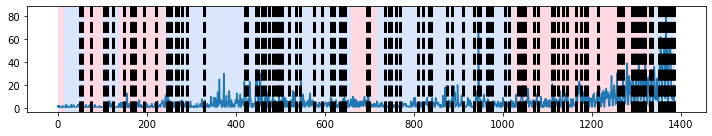

In [9]:
signal = np.concatenate([
    daily_occurence_sums.reshape(-1, 1), 
    daily_occurence_count.reshape(-1, 1),
    daily_occupations.reshape(-1, 1),
    daily_embeddings_mean
], axis=-1)

algo = rpt.Dynp(model="rbf").fit(signal)
result = algo.predict(n_bkps=100)

plt.figure(figsize=(20, 15))
rpt.display(signal[:, 1], date_idx, result)
plt.show()

> Lets now take the important dates found by the algorithm and found which people quotes were published on this dates 

In [10]:
valuable = df[df["publish_date"].isin(daily_occurence_dates[result[:-1]])].groupby("s").sum()["o"].reset_index().values

In [11]:
people_freq = sorted(valuable.tolist(), key=lambda x: x[1], reverse=True)
people_freq[:30]

[['adrian lee', 512],
 ['craig wright', 325],
 ['mark karpeles', 293],
 ['campbell harvey', 99],
 ['gavin andresen', 88],
 ['jason english', 79],
 ['andrew bailey', 74],
 ['doug barrowman', 66],
 ['didi taihuttu', 63],
 ['vladimir putin', 61],
 ['paul donovan', 60],
 ['shmuel hauser', 56],
 ['brian armstrong', 53],
 ['michael mccarthy', 53],
 ['tom lee', 53],
 ['bobby lee', 44],
 ['sergei shvetsov', 44],
 ['gregory maxwell', 43],
 ['ken moore', 40],
 ['roger ver', 40],
 ['alex tapscott', 37],
 ['mark palmer', 36],
 ['lisa kramer', 33],
 ['valdis dombrovskis', 33],
 ['warren buffett', 33],
 ['bridget van kralingen', 32],
 ['tom budin', 32],
 ['john mcafee', 28],
 ['sean sullivan', 28],
 ['jeffrey robinson', 26]]

> Putin??

> Next lets find the most similar persons, according to their quotes

In [12]:
df = df.sort_values("s")

In [13]:
people_embeddings = np.stack(
    pd.DataFrame(df['embd'].tolist(), index=df['s']).mean(level=0).agg(np.array, 1).values, 
axis=-1).T
people_ids = pd.DataFrame(df['embd'].tolist(), index=df['s']).mean(level=0).agg(np.array, 1).index.values

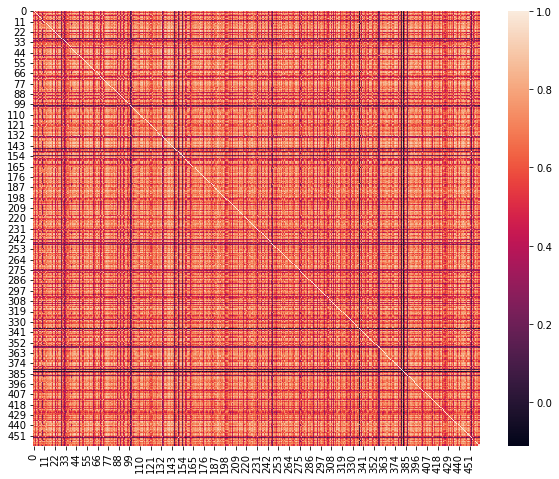

In [14]:
import seaborn as sns

plt.figure(figsize=(10,8))
norm_ = people_embeddings / np.linalg.norm(people_embeddings, axis=-1, keepdims=True)
similarity = norm_ @ norm_.T
sns.heatmap(similarity)

In [15]:
knn = similarity.argsort(axis=-1)[:, -6:-1]

In [16]:
id2person = {i: p for i, p in enumerate(people_ids)}
person2id = {p: i for i, p in enumerate(people_ids)}

In [17]:
for p, f in people_freq[:6]:
    print(p, f)
    print([id2person[elem] for elem in knn[person2id[p]]])

adrian lee 512
['wences casares', 'andreas antonopoulos', 'jamie dimon', 'david yermack', 'roger ver']
craig wright 325
['craig steven wright', 'charlie shrem', 'erik voorhees', 'andreas antonopoulos', 'gavin andresen']
mark karpeles 293
['charlie shrem', 'wences casares', 'andreas antonopoulos', 'gavin andresen', 'roger ver']
campbell harvey 99
['vinny lingham', 'fred wilson', 'vitalik buterin', 'emin gün sirer', 'andreas antonopoulos']
gavin andresen 88
['marc andreessen', 'amir taaki', 'erik voorhees', 'roger ver', 'andreas antonopoulos']
jason english 79
['gavin smith', 'pan gongsheng', 'panos mourdoukoutas', 'mark mobius', 'bobby lee']


------

In [18]:
df['publish_year'] = df['d'].apply(lambda x: x[:4])

In [19]:
for year in np.unique(df.publish_year.values):
    line = df[df.publish_year == year].sort_values('o', ascending=False).head(1)
    
    print(f'--{year}')
    print(f'Speaker: {line.s.values[0]}') 
    print(f'Count: {line.o.values[0]}')

--2008
Speaker: george orwell
Count: 6
--2009
Speaker: gore vidal
Count: 16
--2010
Speaker: president barack obama
Count: 24
--2011
Speaker: paul krugman
Count: 26
--2012
Speaker: gore vidal
Count: 25
--2013
Speaker: edward snowden
Count: 182
--2014
Speaker: mark karpeles
Count: 258
--2015
Speaker: adrian lee
Count: 128
--2016
Speaker: craig wright
Count: 51
--2017
Speaker: thomas peterffy
Count: 463


In [20]:
def moving_average(data, window=7, stride=1) :
    window_averages = []
        
    range_end = len(data)
    for window_first_day in range(0, range_end, stride):
        window_last_day = min(window_first_day + window, range_end)
        mean = data[window_first_day: window_last_day].mean()
        window_averages.append(mean)
    
    return np.array(range(0, range_end, stride)), window_averages

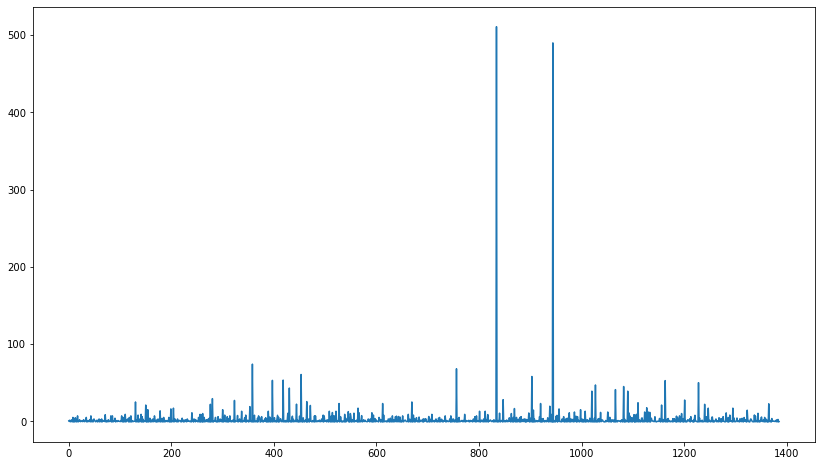

In [21]:
plt.figure(figsize=(14, 8))
plt.plot((daily_occurence_sums[1:] - daily_occurence_sums[:-1]) / daily_occurence_sums[:-1])
plt.show()

In [50]:
import plotly.express as px

window_first_day_numbers, window_averaged_occurences = moving_average(
    daily_occurence_sums, 
    window=WINDOW_DAYS,
    stride=WINDOW_DAYS
)
window_first_date = [daily_occurence_dates[i] for i in window_first_day_numbers]

fig = px.line(x=window_first_date, 
              y=window_averaged_occurences,
              labels=dict(x="Date", y="Count"),
              title="Number of quote occurences by date (7 Day Moving Average)")

fig.write_html('quote_occurence_7day_ma.html')
fig.show()

In [51]:
def relative_difference(data, shift=1):
    data_shifted = np.roll(data, shift)  # data_shifted[t] = data[t - shift] 
    data_differences = ((data - data_shifted ) / data_shifted)[shift:]
    return data_differences

In [98]:
occurence_differences = relative_difference(window_averaged_occurences, 1)



first_plot = np.array(window_averaged_occurences[-len(occurence_differences):] ) / 10
second_plot = occurence_differences


fig = px.line(labels=dict(x="Date"), title="Quote occurences and their relative change by dates")

fig.add_scatter(x=window_first_date[1:], y=first_plot, name="quote occurences / 10")
fig.add_scatter(x=window_first_date[1:], y=second_plot, name="relative change",)

fig.layout['legend'] = {"title": "Legend"}
fig.write_html("quote_occurence_change_by_date.html")
fig.show()

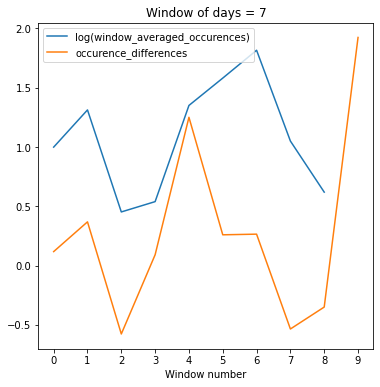

In [23]:
RIGHT_WINDOW_LIMIT = 10

first_plot = np.log(window_averaged_occurences[-len(occurence_differences): RIGHT_WINDOW_LIMIT])
second_plot = occurence_differences[:RIGHT_WINDOW_LIMIT]

plt.figure(figsize=(6, 6))
plt.plot(first_plot)
plt.plot(second_plot)
plt.title(f'Window of days = {WINDOW_DAYS}')
plt.legend(['log(window_averaged_occurences)', 'occurence_differences'])
plt.xlabel('Window number')
plt.xticks(range(RIGHT_WINDOW_LIMIT))
plt.show()

In [24]:
window_first_date[6], window_first_date[8]

('2009-10-16', '2010-01-12')

In [25]:
DAYS_LEFT_LIMIT = window_first_date[6]
# +1 because window are labeled by their first day, and we want to see the whole 7th window
DAYS_RIGHT_LIMIT = window_first_date[7 + 1]

print(f"The period of interest is from {DAYS_LEFT_LIMIT} to {DAYS_RIGHT_LIMIT}")

The period of interest is from 2009-10-16 to 2010-01-12


In [26]:
df_of_interest = df[(DAYS_LEFT_LIMIT <= df['publish_date']) & (df['publish_date'] < DAYS_RIGHT_LIMIT)]
df_of_interest.head()

,q,d,s,o,gender,birth,occupation,publish_date,occupation_i,embd,publish_year
69,little bit confused here in other words you ha...,2009-11-30 16:40:42,alan greenspan,1,male,['+1926-03-06T00:00:00Z'],economist,2009-11-30,34,"[0.0026998457, 0.02766724, -0.048748318, -0.05...",2009
55,quantum cryptography ensures secrecy between n...,2009-10-30 03:59:05,andrew shields,1,male,['+2000-01-01T00:00:00Z'],physicist,2009-10-30,26,"[-0.046907973, 0.09471482, -0.042648975, 0.109...",2009
52,our network uses a combination of quantum and ...,2009-10-30 03:59:05,andrew shields,1,male,['+2000-01-01T00:00:00Z'],physicist,2009-10-30,26,"[-0.041865997, 0.001300144, -0.053100444, 0.03...",2009
95,its really onerous its a stupid crypto mistake...,2010-01-08 19:20:21,bruce schneier,4,male,['+1963-01-15T00:00:00Z'],cryptographer,2010-01-08,41,"[-0.06816631, 0.06953237, 0.04124821, -0.00051...",2010
22,not published the cryptographic background to ...,2009-10-30 03:59:10,bruce schneier,1,male,['+1963-01-15T00:00:00Z'],cryptographer,2009-10-30,41,"[0.0074799736, 0.11582837, -0.04962184, 0.0455...",2009


In [27]:
df_of_interest.sort_values('o', ascending=False).head()

,q,d,s,o,gender,birth,occupation,publish_date,occupation_i,embd,publish_year
33,any cryptographic function is a one way street,2009-12-29 12:12:02,karsten nohl,13,male,['+1981-08-11T00:00:00Z'],engineer,2009-12-29,36,"[-0.075517386, 0.023561805, -0.029546598, 0.03...",2009
39,we need to carefully watch this debate as it c...,2009-11-20 16:08:07,sarah palin,7,female,['+1964-02-11T00:00:00Z'],politician,2009-11-20,30,"[0.009096838, -0.036693238, -0.038596738, 0.01...",2009
36,now listen you queer stop calling me a crypton...,2009-12-10 18:07:01,gore vidal,5,male,['+1925-10-03T00:00:00Z'],writer,2009-12-10,58,"[-0.006793968, -0.019819887, -0.042647246, -0....",2009
46,as far as im concerned the only sort of procry...,2009-12-10 18:07:01,gore vidal,5,male,['+1925-10-03T00:00:00Z'],writer,2009-12-10,58,"[-0.027255792, -0.013926937, -0.11780756, -0.0...",2009
27,any cryptographic function is a one way street...,2009-12-30 08:41:20,karsten nohl,4,male,['+1981-08-11T00:00:00Z'],engineer,2009-12-30,36,"[-0.06351935, 0.038392898, -0.049199186, -0.00...",2009


In [28]:
df_of_interest.sort_values('o', ascending=False).head()['q']

33       any cryptographic function is a one way street
39    we need to carefully watch this debate as it c...
36    now listen you queer stop calling me a crypton...
46    as far as im concerned the only sort of procry...
27    any cryptographic function is a one way street...
Name: q, dtype: object